In [1]:
import sys
sys.path.append("/home/oldrain123/IMBALANCED_CLASSIFICATION/MOMs")
sys.path.append('/home/oldrain123/IMBALANCED_CLASSIFICATION/')

In [2]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
DEVICE = "cuda"
print(f"Using device: {DEVICE}")

Using device: cuda


/home/oldrain123/anaconda3/envs/imb_clf/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[Saved] half_moon_synthetic.pdf


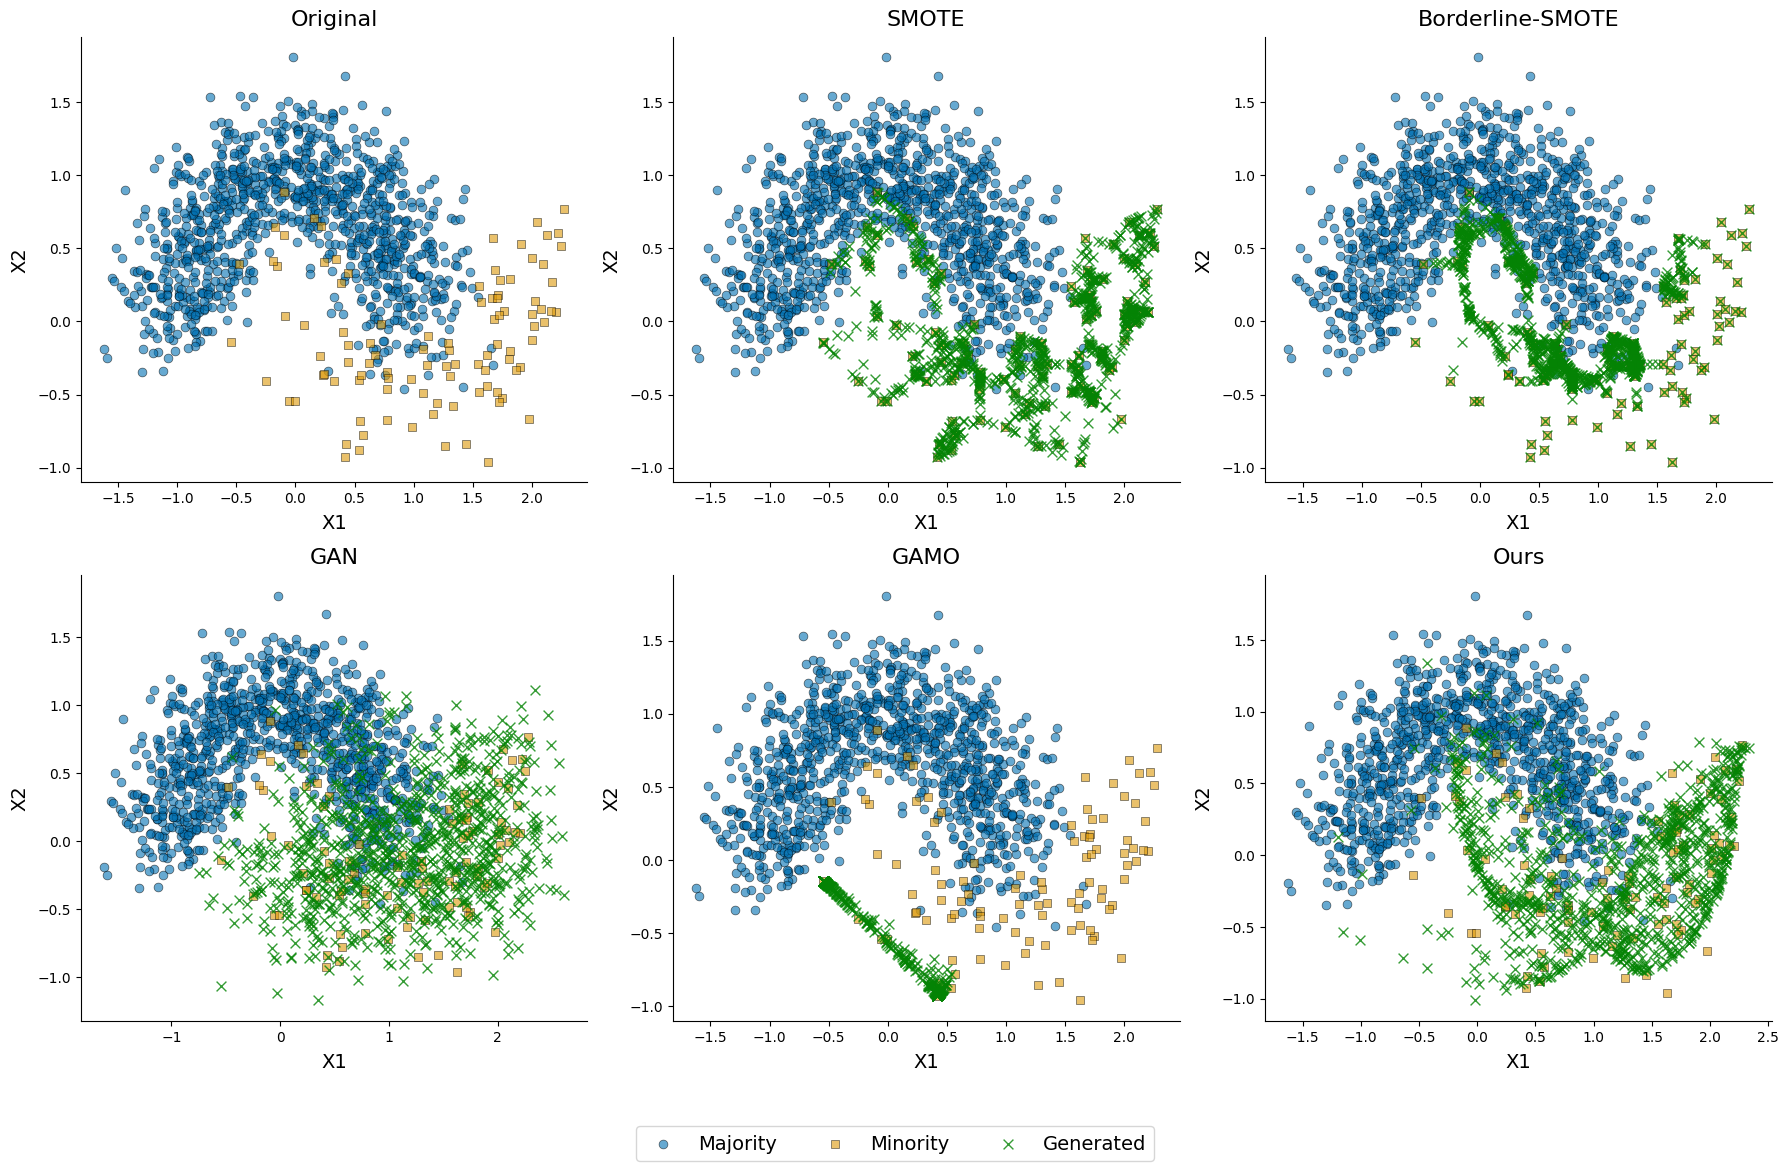

[Saved] gaussian_blob_synthetic.pdf


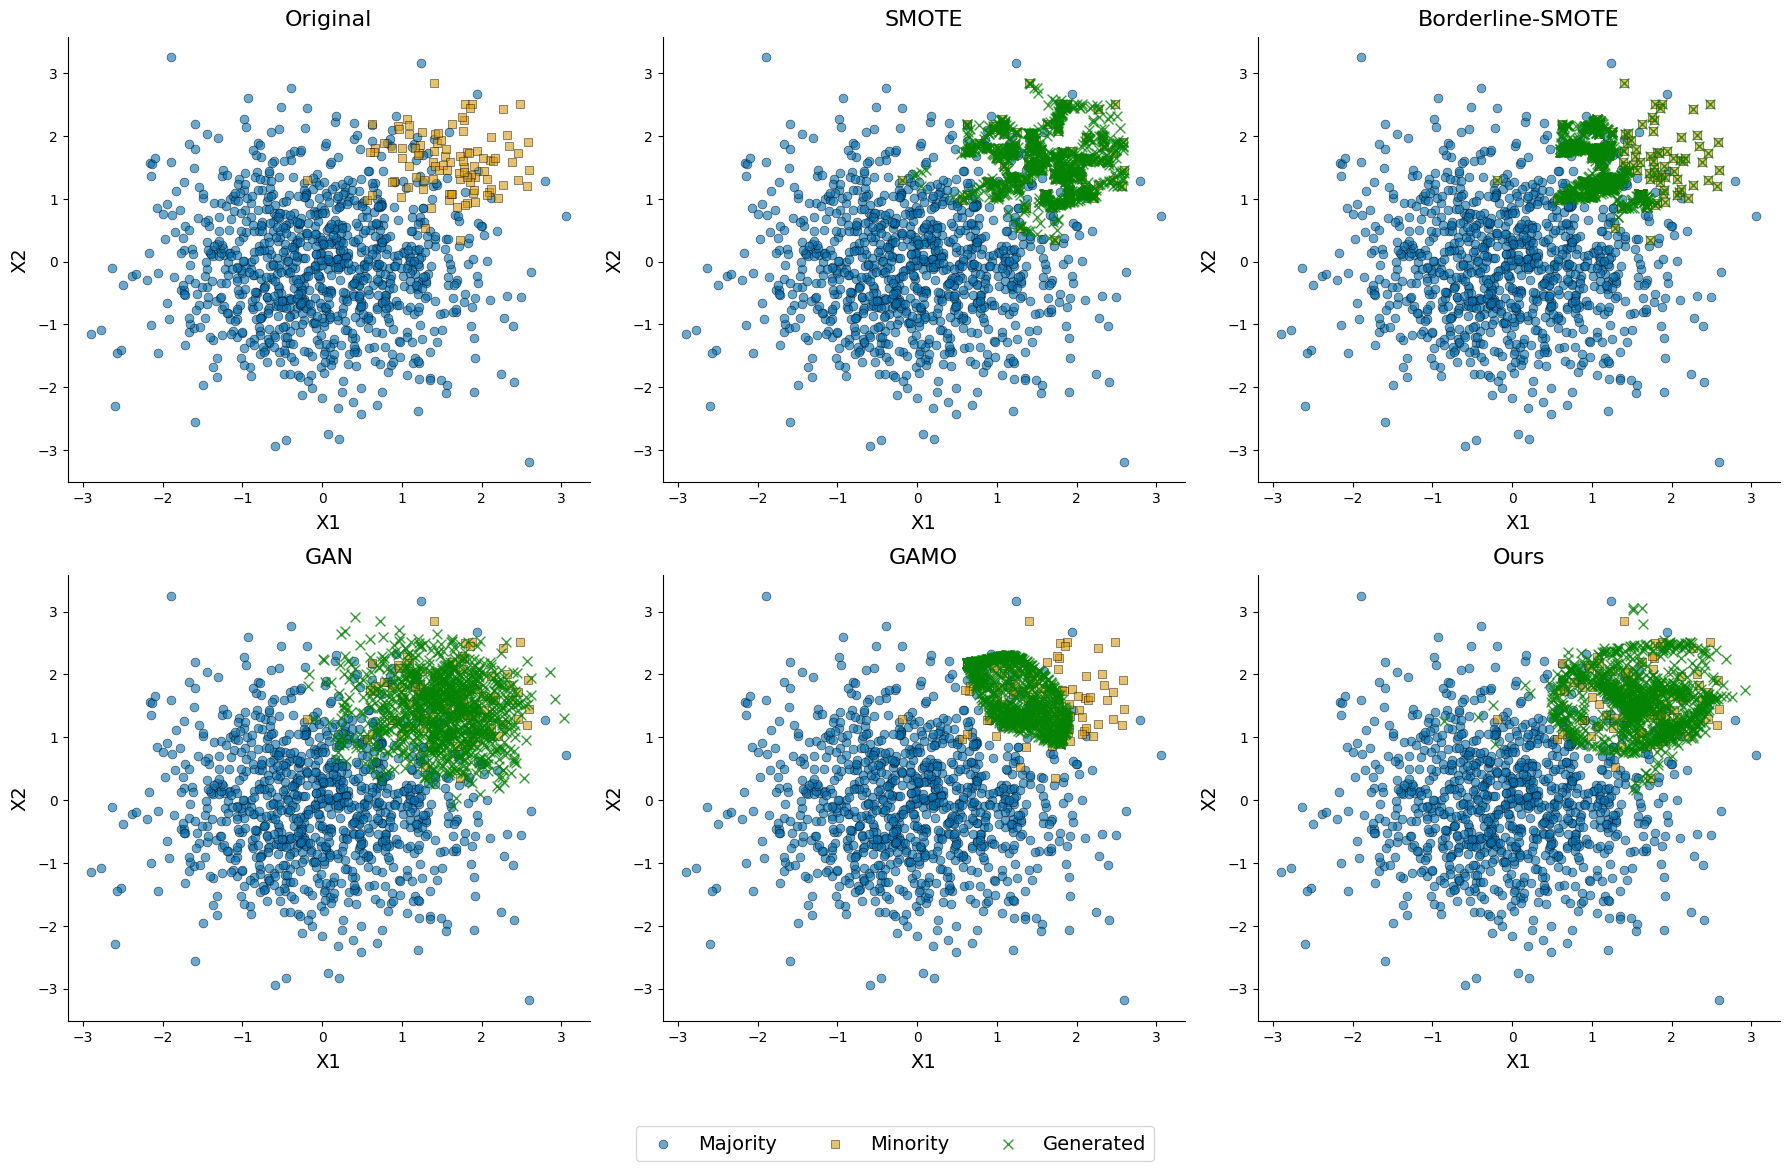

In [3]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_blobs
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from ctgan import CTGAN

from moms_generate import transform as moms_transform
from moms_losses import MMD_est_torch
from moms_visualize import visualize_samples
from moms_utils import set_seed
from gamosampler import GAMOtabularSampler
from mgvae import MGVAE

SEED = 1203
N_SAMPLES = 2000
N_MINORITY_SAMPLES = 100
NOISE = 0.25

set_seed(SEED)

def generate_half_moon_data(n_total, n_min_subsample, noise, seed):
    X, y = make_moons(n_samples=n_total, noise=noise, random_state=seed)
    X_maj = X[y == 0]
    X_min = X[y == 1]
    subsample_indices = np.random.choice(X_min.shape[0], n_min_subsample, replace=False)
    X_min_sub = X_min[subsample_indices]
    return X_maj, X_min_sub

def generate_gaussian_blob_data(n_total, n_min_subsample, centers=None, stds=None, seed=SEED):
    # centers: list of 2-tuples, stds: list of floats
    if centers is None:
        centers = [(0, 0), (0.5, 0.5)]
    if stds is None:
        stds = [0.5, 1]
    X, y = make_blobs(
        n_samples=n_total,
        centers=centers,
        cluster_std=stds,
        random_state=seed
    )
    X_maj = X[y == 0]
    X_min = X[y == 1]
    subsample_indices = np.random.choice(X_min.shape[0], n_min_subsample, replace=False)
    X_min_sub = X_min[subsample_indices]
    return X_maj, X_min_sub

def run_ctgan_oversampling(X_min, n_samples_to_generate):
    df = pd.DataFrame(X_min, columns=[f'f{i}' for i in range(X_min.shape[1])])
    ctgan = CTGAN(
        epochs=2000,
        embedding_dim=16,
        generator_dim=(32, 64),
        verbose=False
    )
    ctgan.fit(df)
    return ctgan.sample(n_samples_to_generate).values

def run_mgvae_oversampling(
    X_maj,
    X_min,
    n_samples_to_gen,
    device,
    latent_dim=128,
    hidden_dims=[64],
    majority_subsample=None,
    pretrain_epochs=0,
    finetune_epochs=100,
    pretrain_batch_size=1000,
    finetune_batch_size=4,
    lr=1e-3,
    ewc_lambda=0.01
):
    # -- prepare tensors
    X_maj_t = torch.tensor(X_maj, dtype=torch.float32, device=device)
    X_min_t = torch.tensor(X_min, dtype=torch.float32, device=device)

    D = X_maj.shape[1]
    majority_sub = majority_subsample or X_maj.shape[0]

    # -- build model
    model = MGVAE(
        input_dim=D,
        latent_dim=latent_dim,
        hidden_dims=hidden_dims,
        device=device,
        majority_subsample=majority_sub
    )

    # -- two-stage training
    model.fit(
        X_maj_t,
        X_min_t,
        pretrain_epochs=pretrain_epochs,
        finetune_epochs=finetune_epochs,
        batch_size=pretrain_batch_size,
        lr=lr,
        ewc_lambda=ewc_lambda
    )

    # -- generate
    samples = model.sample(X_maj_t, n_samples=n_samples_to_gen)
    return samples

def run_gamo_oversampling(X_maj, X_min, n_samples_to_gen, device):
    # Reconstructed in a manner faithful to the original GAMO
    input_dim = X_min.shape[1]
    n_classes = 2
    class_counts = [len(X_maj), len(X_min)]
    all_minority_X = {0: X_maj, 1: X_min}
    # Only class 1 (minority) generator is relevant in binary half-moon
    sampler = GAMOtabularSampler(
        input_dim=input_dim,
        latent_dim=2,
        hidden_dim=64,
        n_classes=n_classes,
        class_counts=class_counts,
        all_minority_X=all_minority_X,
        device=device
    )
    # Only class 1 instances need be provided; method signature may differ for multi-class
    class_X_dict = {0: X_maj, 1: X_min}
    sampler.fit(class_X_dict, n_epochs=500, lr=1e-3, seed=SEED)
    return sampler.sample(n_samples=n_samples_to_gen, class_id=1)
if __name__ == "__main__":
    experiments = {
        'half_moon': {
            'generator': generate_half_moon_data,
            'params': {
                'n_total': N_SAMPLES,
                'n_min_subsample': N_MINORITY_SAMPLES,
                'noise': NOISE,
                'seed': SEED
            }
        },
        'gaussian_blob': {
            'generator': generate_gaussian_blob_data,
            'params': {
                'n_total': N_SAMPLES,
                'n_min_subsample': N_MINORITY_SAMPLES,
                'centers': [(0,0), (1.5, 1.5)],
                'stds': [1.0, 0.5],
                'seed': SEED
            }
        }
    }

    for name, cfg in experiments.items():
        X_maj, X_min = cfg['generator'](**cfg['params'])
        n_to_gen = X_maj.shape[0] - X_min.shape[0]

        oversamplers = {
            'SMOTE': lambda: SMOTE(random_state=SEED).fit_resample(
                np.vstack([X_maj, X_min]),
                np.hstack([np.zeros(len(X_maj)), np.ones(len(X_min))])
            )[0][len(X_maj):],
            'Borderline-SMOTE': lambda: BorderlineSMOTE(random_state=SEED).fit_resample(
                np.vstack([X_maj, X_min]),
                np.hstack([np.zeros(len(X_maj)), np.ones(len(X_min))])
            )[0][len(X_maj):],
            'GAN':    lambda: run_ctgan_oversampling(X_min, n_to_gen),
            'GAMO':   lambda: run_gamo_oversampling(X_maj, X_min, n_to_gen, DEVICE),
            # 'MGVAE':  lambda: run_mgvae_oversampling(X_maj, X_min, n_to_gen, DEVICE),
            'Ours':   lambda: moms_transform(
                X_maj=X_maj, X_min=X_min, in_dim=2, hidden_dims=[32, 64], latent_dim=16,
                loss_fn=MMD_est_torch, kernel_type='gaussian', device=DEVICE, n_epochs=1000,
                lr=1e-3, beta=0.01, seed=SEED)[2]
        }

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        visualize_samples(axes[0], X_maj, X_min, np.array([]), title="Original")
        for i, (title, fn) in enumerate(oversamplers.items(), 1):
            X_gen = fn()
            visualize_samples(axes[i], X_maj, X_min, X_gen, title=title)
        for j in range(len(oversamplers) + 1, len(axes)):
            axes[j].axis('off')

        wanted = ['Majority','Minority','Generated']
        handles, labels = [], []
        for lbl in wanted:
            for ax in axes:
                h_list, l_list = ax.get_legend_handles_labels()
                for h,l in zip(h_list, l_list):
                    if l==lbl:
                        handles.append(h)
                        labels.append(l)
                        break
                if lbl in labels:
                    break 
            
        # Figure 레전드
        fig.legend(
            handles, labels,
            loc='lower center', ncol=3,
            frameon='True', fontsize=14,
            bbox_to_anchor=(0.5, -0.02)
        )

        plt.tight_layout(rect=[0, 0.05, 1, 0.96])
        out_name = f"{name}_synthetic.pdf"
        plt.savefig(out_name, dpi=400, format='pdf', bbox_inches='tight')
        print(f"[Saved] {out_name}")
        plt.show()
